In [4]:
import sys

sys.path.append("../../src")

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.linalg import eigh
import sto_ng
import sto_ng_overlap_function
import h5py
import gaussian_overlap_function
import os


importlib.reload(sto_ng)
importlib.reload(sto_ng_overlap_function)
importlib.reload(gaussian_overlap_function)
from sto_ng import *
from sto_ng_overlap_function import *
from gaussian_overlap_function import *

In [6]:
with h5py.File("../make_base/sto_ng.h5", "r") as f:
    alphas = f["1s/sto-3g/alpha"][:]
    cs = f["1s/sto-3g/c"][:]
alphas = np.array(alphas)
cs = np.array(cs)
cs_new = cs * (2 * alphas / np.pi) ** (3 / 4)

In [14]:
def get_total_energy(stong, zetas, Rs, initial_c_sto3g_up, initial_c_sto3g_dn):
    stongmatrix = StoNGMatrix(stong, zetas, Rs)
    s_mat = stongmatrix.get_smat()
    h_mat = stongmatrix.get_h_mat([1, 1])
    new_total_energy = 0
    c_sto3g_up = initial_c_sto3g_up
    c_sto3g_dn = initial_c_sto3g_dn
    for i in range(1000):
        J_mat_up = stongmatrix.get_J_mat(c_sto3g_dn)
        fock_mat_up = h_mat + J_mat_up

        J_mat_dn = stongmatrix.get_J_mat(c_sto3g_up)
        fock_mat_dn = h_mat + J_mat_dn

        valup, vecup = eigh(fock_mat_up, s_mat)
        valdn, vecdn = eigh(fock_mat_dn, s_mat)

        c_sto3g_up = 0.9 * c_sto3g_up + 0.1 * vecup[:, 0]
        c_sto3g_dn = 0.9 * c_sto3g_dn + 0.1 * vecdn[:, 0]
        old_total_energy = new_total_energy
        new_total_energy = (
            valup[0]
            + valdn[0]
            - vecup[:, 0] @ J_mat_up @ vecup[:, 0] / 2
            - vecdn[:, 0] @ J_mat_dn @ vecdn[:, 0] / 2
        )
        if i > 0 and abs(new_total_energy - old_total_energy) < 1e-6:
            break
    return new_total_energy + 1 / np.linalg.norm(Rs[1] - Rs[0]), c_sto3g_up, c_sto3g_dn

In [24]:
stong = StoNG(cs_new, alphas)
zetaH = 1.24
zetas = [zetaH, zetaH]
rs = np.linspace(0.5, 6, 100)
Rs = [np.array([[0, 0, 0], [0, 0, r]]) for r in rs]
total_energies = []
# total_energies = np.array([get_total_energy(stong, zetas, R) for R in Rs])
c_sto3g_up = np.array([0.6, 0.4])
c_sto3g_dn = np.array([0.4, 0.6])
for i, r in enumerate(reversed(rs)):
    print(i)
    Rs = np.array([[0, 0, 0], [0, 0, r]])
    total_energy, c_sto3g_up, c_sto3g_dn = get_total_energy(
        stong, zetas, Rs, c_sto3g_up, c_sto3g_dn
    )
    total_energies.insert(0, total_energy)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0, 0.5, 'E(H2) - 2E(H) (a. u.)')

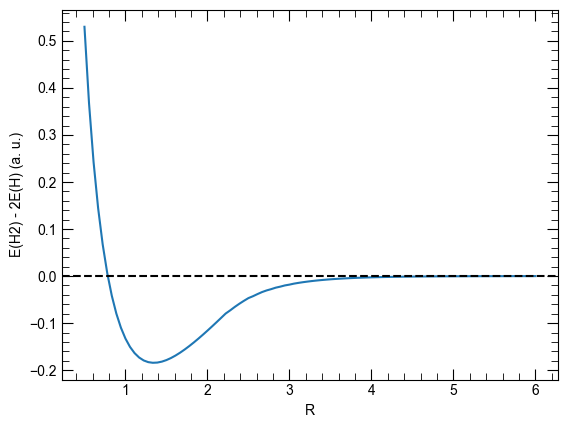

In [25]:
fig, ax = plt.subplots()
ax.plot(rs, np.array(total_energies) + 2 * 0.4666)
ax.axhline(0, color="black", linestyle="--")
ax.set_xlabel("R")
ax.set_ylabel("E(H2) - 2E(H) (a. u.)")

In [29]:
os.makedirs("../data/total_energies", exist_ok=True)
np.save("../data/total_energies/uhf.npy", np.array(total_energies) + 2 * 0.4666)